<div align="center">
  <img src="https://raw.githubusercontent.com/lapalap/invert/main/assets/images/logo.svg" width="400"/>
</div>

<div align="center"><h1>Hello INVERT</h1>
<h5>Notebook demonstrates basic properties of the proposed approach</h5>

Cloning the repository and installing the INVERT

In [1]:
! git clone https://github.com/lapalap/invert.git --quiet
! pip install git+file:///content/invert --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.8 MB/s eta 0:00:00


Importing necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

from invert.explainer import Invert

import torch
import pandas as pd
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1.  Loading the data

To make INVERT function properly, we need to get the activation values of neurons for a particular dataset, along with the corresponding concept labels. In this example, we fetch the activation tensor from the ResNet18 AvgPool layer (512 nerurons) using the ImageNet validation dataset, which consists of 50,000 images. Additionally, we retrieve sets of concept labels for each image.

In [2]:
# in this demo we download activations -- set this varibale to True to collect activations by yourself
from invert.utils import ImageDataset, IMAGENET_TRANSFORMS
from tqdm import tqdm
import torchvision

extract_activations = True

# if set to True provide path to dataset, i.e. Imagenet validation
PATH = '/mnt/beegfs/share/atbstaff/ImageNet_1k/ILSVRC/Data/CLS-LOC/val/'

if extract_activations:
    testset = ImageDataset(PATH, transform = IMAGENET_TRANSFORMS)
    testloader = torch.utils.data.DataLoader(testset,
                                            batch_size=128,
                                            shuffle=False,
                                            num_workers=32)
    
    model = torchvision.models.resnet18(pretrained = True).eval().to(device)
    
    # put hook on layer
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.data
        return hook

    model.avgpool.register_forward_hook(get_activation('avgpool'))

    A = torch.zeros([len(testset),512]).cpu()

    counter = 0

    with torch.no_grad():
        for i, x in tqdm(enumerate(testloader)):
            x = x.float().data.to(device)

            outputs = model(x).data
            # avgpool layer has shape [B, 512, 1, 1]
            A[counter:counter + x.shape[0],:] = activation['avgpool'][:, :, 0, 0].data.cpu()
            counter += x.shape[0]
else:
    # Downloading ResNet18 AvgPool layer activations across ImageNet validation dataset
    ! wget -O A50k_resnet18_avgpool.tnsr https://www.dropbox.com/scl/fi/9j6x953n7d504hgtn5eaa/A50k_avgpoolresnet18_val.tnsr?rlkey=tx9wz371p5m541799qzr18ybq&dl=0 --quiet
    A = torch.load("/content/A50k_resnet18_avgpool.tnsr")

print(A.shape)

/mnt/beegfs/home/bykov1/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/beegfs/home/bykov1/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
391it [01:07,  5.77it/s]

torch.Size([50000, 512])


In [25]:
# Downloading labels of ImageNet validation dataset
! wget https://www.dropbox.com/scl/fi/d7silvnhen7mujts1h6by/ILSVRC2012_val.csv?rlkey=svo4g8f4wegx4ijo3pwfe3p6p&dl=0

Each image is associated with a one-hot-encoding vector that represents the concepts it relates to. We expanded the initial set of 1,000 ImageNet classes by adding 481 hypernyms, representing higher-level concepts. Consequently, each image is now labeled with a total of 1,481 concepts. It's important to note that an image can have multiple labels.

In [3]:
df = pd.read_csv('/mnt/beegfs/share/atbstaff/BigConcepts/ILSVRC2012_val.csv') #1481 class
one_hot_labels = torch.tensor(df[df.columns[1:]].values).bool()
torch.save(one_hot_labels, 'one_hot_labels.tnsr')

In [4]:
df

,image_name,n01440764,n01443537,n01484850,n01491361,n01494475,n01496331,n01498041,n01514668,n01514859,...,n09433442,n09613191,n00007846,n13135832,n11669921,n11665372,n11552386,n13083586,n00017222,n12992868
0,ILSVRC2012_val_00000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ILSVRC2012_val_00000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ILSVRC2012_val_00000003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ILSVRC2012_val_00000004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ILSVRC2012_val_00000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,ILSVRC2012_val_00049996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,ILSVRC2012_val_00049997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,ILSVRC2012_val_00049998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,ILSVRC2012_val_00049999,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


The cloned repository contains a JSON file where we've gathered information and metadata about all 1,481 concepts used for the explanations.

In [5]:
#data = open('/content/invert/assets/imagenet/ILSVRC2012_classes.json')
data = open('assets/imagenet/ILSVRC2012_classes.json')
data = data.read()
data = json.loads(data)

/tmp/ipykernel_135795/1801734244.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='assets/imagenet/ILSVRC2012_classes.json' mode='r' encoding='UTF-8'>
  data = data.read()


In [6]:
print(data['0'])

{'name': 'tench.n.01', 'definition': 'freshwater dace-like game fish of Europe and western Asia noted for ability to survive outside water', 'offset': 'n01440764'}


In [7]:
print(data['1'])

{'name': 'goldfish.n.01', 'definition': 'small golden or orange-red freshwater fishes of Eurasia used as pond or aquarium fishes', 'offset': 'n01443537'}


# 2. INVERT explanation

Following that, we proceed with the inversion explanation for neuron 296 in the AveragePooling layer of the ResNet18 model. Our first step involves initializing the Invert and loading the activations. 

First, we initialize Invert class and load the data labebls in a form of one-hot-encoded data.

In [8]:
explainer = Invert(
        device = device,
    )

explainer.load_concept_labels(labels_path='one_hot_labels.tnsr',
                              description_path='assets/imagenet/ILSVRC2012_classes.json'
                              )

Now we can run the INVERT procedure for the neuron 296. We set L = 3, B = 3, and $\alpha$ = 0.002.

In [9]:
r = 296
L = 3
B = 3

explanation = explainer.explain_representation(A = A[:, r],
                                  L = L,
                                  B = B,
                                  min_fraction=0.002
                                  )

best_explanation = explanation[0]
best_explanation

/mnt/beegfs/home/bykov1/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/mnt/beegfs/home/bykov1/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


{'formula': n02883344 & ~n03710193 & ~n03908618,
 'length': 3,
 'metric': tensor(0.9090, device='cuda:0'),
 'differentiability': tensor(0.8181, device='cuda:0'),
 'concept_fraction': tensor(0.0040, device='cuda:0')}

Resulting formula achieves AUROC of 0.9151 and has a support of 0.4% (200 images) of the dataset.

In the process of generating formulas, concepts are encoded using their corresponding WordNet offset. We can translate this into a more human-understandable form.

We can take a look at the "support" of the explanation -- set of datapoints, that correspond to the resulting explanation.

In [14]:
def find_by_offset(search_value:str, d:dict):
  for k in d:
    if d[k]['offset'] == search_value:
      return d[k]

print("Explanation for neuron {r}: ".format(r = r))
print(best_explanation['formula'])

human_readable_explanation = str(best_explanation['formula'])

print('\nHuman-understandable concepts: ')
for element in best_explanation['formula']._distinct_concepts:
  label = find_by_offset(str(element), data)
  print(element, label['name'], label['definition'])
  human_readable_explanation = human_readable_explanation.replace(str(element), label['name'])

print('\nHuman-readable explanation: {e}'.format(e = human_readable_explanation))

Explanation for neuron 296: 
n02883344 & ~n03710193 & ~n03908618

Human-understandable concepts: 
n03908618 pencil_box.n.01 a box for holding pencils
n02883344 box.n.01 a (usually rectangular) container; may have a lid
n03710193 mailbox.n.01 a private box for delivery of mail

Human-readable explanation: box.n.01 & ~mailbox.n.01 & ~pencil_box.n.01


We can take a look at a labels for the explanation

In [15]:
buffer = best_explanation['formula'](explainer.memdict).cpu()
print(buffer.shape)
print(buffer.sum())

torch.Size([50000])
tensor(200)


We can visualize the difference in the activation distribution of neuron 296 across data points corresponding to the explanation versus all other data points.

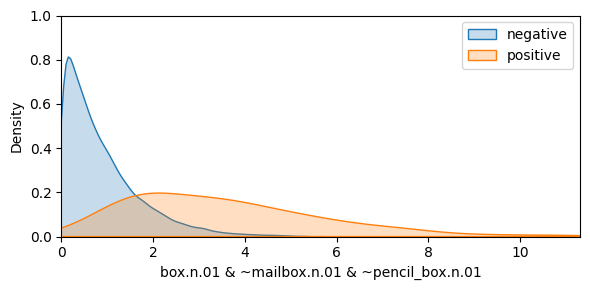

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

ig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=A[buffer == False, r],
            color='tab:blue', label='negative', fill=True, ax=ax)
sns.kdeplot(data=A[buffer == True, r],
            color='tab:orange', label='positive', fill=True, ax=ax)

ax.set_ylim((0, 1.))
ax.set_xlim((0, A[:, r].max()))
ax.legend()
ax.set_title('')
ax.set_xlabel(human_readable_explanation)
plt.tight_layout()
plt.show()

We can observe that indeed, activations of the data points corresponding to the resulting explanation (in orange) are generally significantly higher than for all other points (in blue).

Furthermore, we can conduct a statistical significance check to ensure that this difference is not merely a random occurrence.

In [17]:
explainer.get_p_value(A[:, r], best_explanation['formula'])

5.653367450294752e-89

We observe that the p-value is very small, which enables us to assert the statistical significance of the result.

# 3. Checking on local explanations

To further illustrate the behavior of the studied neuron, we can closely examine its local explanations. For this purpose, we gathered several images of boxes and visualized Grad-Cam explanations for neuron 296.

In [21]:
!pip install grad-cam --quiet

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We download several images of boxes from wikimedia.

In [22]:
! wget -O box1.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Large_Wooden_box.jpg/800px-Large_Wooden_box.jpg --quiet
! wget -O box2.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Cardboard_box_with_cyan_background.png/640px-Cardboard_box_with_cyan_background.png --quiet
! wget -O box3.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Elaborate_wood_box_Tom_Tanaka.JPG/640px-Elaborate_wood_box_Tom_Tanaka.JPG --quiet
! wget -O box4.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/L%C3%A5da_-_Livrustkammaren_-_107142.tif/lossy-page1-640px-L%C3%A5da_-_Livrustkammaren_-_107142.tif.jpg --quiet
! wget -O box5.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Box%2C_jewellery_%2851369557639%29.jpg/640px-Box%2C_jewellery_%2851369557639%29.jpg --quiet
! wget -O box6.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Box_%2851361082165%29.jpg/640px-Box_%2851361082165%29.jpg --quiet

Define some transformations before passing images to the network.

In [23]:
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as F

class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

transform = transforms.Compose([
 SquarePad(),
 transforms.Resize(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

Collect Grad-Cam explanations for the neuron 296.

In [24]:
from torchvision import models
from tqdm import tqdm
import glob

model_stripped = models.resnet18(pretrained=True)
model_stripped.fc = torch.nn.Identity()

target_layers = [model_stripped.layer3[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_stripped, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(r)]

images = []
local_explanations = []
for image_path in tqdm(glob.glob('box*')):
  img = Image.open(image_path)
  transformed_img = transform(img)
  input = transform_normalize(transformed_img).unsqueeze(0)

  images.append(transformed_img)
  grayscale_cam = cam(input_tensor=input, targets=targets)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(transformed_img.transpose(0,1).transpose(1,2).numpy(), grayscale_cam, use_rgb=True)
  local_explanations.append(visualization)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.3MB/s]
100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


We can visualize downloaded images alongside Grad-Cam explanations.

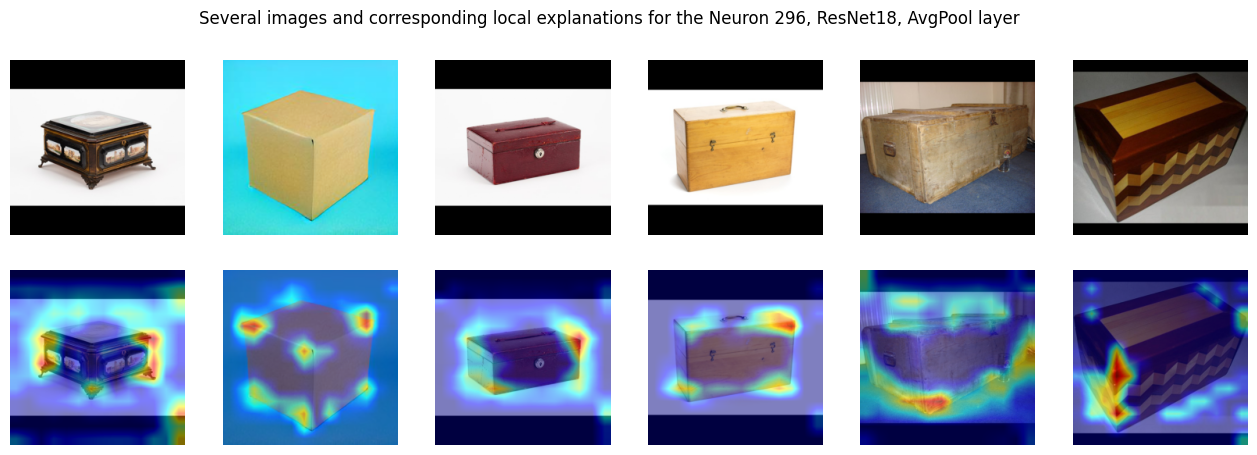

In [25]:
fig, axs = plt.subplots(2, len(images), figsize=(16,5))

fig.suptitle('Several images and corresponding local explanations for the Neuron {r}, ResNet18, AvgPool layer'.format(r=r))

for i in range(len(images)):
  axs[0][i].imshow(images[i].transpose(0,1).transpose(1,2))
  axs[0][i].set_axis_off()
  axs[1][i].imshow(local_explanations[i])
  axs[1][i].set_axis_off()


From this, we can observe that indeed this neuron detects square-shaped box-like objects, as suggested by the INVERT method.

In summary, INVERT offers a straightforward approach to link neurons with human-understandable concepts they detect. The metric of alignment between explanation and the neuron (AUROC) is easily interpretable and enables statistical significance testing. By labeling neurons within the models, we can explain interesting circuits within the models, further enhancing our understanding of their decision-making processes.